## CRC183 Summer School "Machine Learning in Condensed Matter Physics"

# Ground-State Variational Search with NetKet

In this Tutorial we will introduce the open-source package [NetKet](https://www.netket.org/), and show some of its functionalities. We will guide you through a relatively simple quantum problem, that however will be a good guide also to address more complex situations. 

Specifically, we will study the transverse-field Ising model in one dimension: 

$$ 
\mathcal{H}=\Gamma\sum_{i}\sigma_{i}^{(x)}+V\sum_{i}\sigma_{i}^{(z)}\sigma_{i+1}^{(z)}. 
$$

In the following we assume periodic boundary conditions and we will count lattice sites starting from $ 0 $, such that $ i=0,1\dots L-1 $ and $i=L=0$. 

## 0. Installing Netket 

Installing NetKet is relatively straightforward. For this Tutorial, if you are running it locally on your machine, we recommend that you create a clean virtual environment and install NetKet within: 

```bash
python3 -m venv netket
source netket/bin/activate
pip install --pre netket
```

If you are wondering why we use the flag ```--pre``` it is because today we will be working on a pre (beta) release of version 3.0. 

You can check that the installation was succesfull doing 

In [1]:
import netket as nk

## 1. Defining The Hamiltonian

The first step in our journey consists in defining the Hamiltonian we are interested in. 
For this purpose, we first need to define the kind of degrees of freedom we are dealing with (i.e. if we have spins, bosons, fermions etc). This is done specifying the Hilbert space of the problem. For example, let us concentrate on a problem with 20 spins. 

In [2]:
N=20

hi = nk.hilbert.Spin(s=1 / 2, N=N)

We now need to specify the Hamiltonian. For this purpose, we will use NetKet's ```LocalOperator``` (see details [here](https://www.netket.org/docs/_generated/operator/netket.operator.LocalOperator.html#netket.operator.LocalOperator)) which is the sum of arbitrary k-local operators. 

In this specifc case, we have a 1-local operator, $ \sigma^{(x)}_i $ and a 2-local operator, $ \sigma^{(z)}_i \sigma^{(z)}_j $. We then start importing the pauli operators. 



In [3]:
from netket.operator.spin import sigmax,sigmaz 

We now take $ \Gamma=-1 $ and start defining the 1-local parts of the Hamiltonian 

In [4]:
Gamma=-1
H = sum([Gamma*sigmax(hi,i) for i in range(N)])

Here we have used a list comprehension to (mildly) show off, and also because it is typically more efficient than doing a for loop in Python, however you could have just added the terms one by one in an explicit loop instead. 

We now also add the interaction terms, using the fact that NetKet automatically recognizes products of local operators as tensor products. 

In [5]:
V=-1
H += sum([V*sigmaz(hi,i)*sigmaz(hi,(i+1)%N) for i in range(N)])

## 2. Exact Diagonalization

Now that we have defined the Hamiltonian, we can already start playing with it. For example, since the number of spins is large but still manageable for exact diagonalization, we can give it a try. 

In NetKet this is easily done converting our Hamiltonian operator into a sparse matrix of size $ 2^N \times 2^ N $. 

In [6]:
sp_h=H.to_sparse()
sp_h.shape

(1048576, 1048576)

Since this is just a regular scipy sparse matrix, we can just use any sparse diagonalization routine in there to find the eigenstates. For example, this will find the two lowest eigenstates  

In [7]:
from scipy.sparse.linalg import eigsh

eig_vals, eig_vecs = eigsh(sp_h, k=2, which="SA")

print("eigenvalues with scipy sparse:", eig_vals)

eigenvalues with scipy sparse: [-25.49098969 -25.41240947]


## 3. Mean-Field Ansatz

We now would like to find a variational approximation of the ground state of this Hamiltonian. As a first step, we can try to use a very simple mean field ansatz: 

$$ \langle \sigma^{z}_1,\dots \sigma^{z}_N| \Psi_{\mathrm{mf}} \rangle = \Pi_{i=1}^{N} \Phi(\sigma^{z}_i), $$

where the variational parameters are the single-spin wave functions, which we can further take to be normalized: 

$$ |\Phi(\uparrow)|^2 + |\Phi(\downarrow)|^2 =1, $$

and we can further write $ \Phi(\sigma^z) = \sqrt{P(\sigma^z)}e^{i \theta(\sigma^z)}$. In order to simplify the presentation, we take here and in the following examples the phase $ \Phi=0 $. In this specific model this is without loss of generality, since it is known that the ground state is real and positive. 

For the normalized single-spin probability we will take a sigmoid form: 

$$ P(\sigma_z; \lambda) = 1/(1+\exp(-\lambda \sigma_z)) $$, thus depending on the real-valued variational parameter $\lambda$. 

In NetKet, we can use arbitrary Flax models (or just Jax models) to express the **logarithm** of the variational wave-function amplitudes. In this case, the parameter of the model will be just one: $\gamma$.  

In [8]:
import flax
import flax.linen as nn
import jax.numpy as jnp

class MF(nn.Module):
    @nn.compact
    def __call__(self, x):

        lam = self.param(
            "lambda", nn.initializers.normal(), (1,), float
        )

        # compute the probabilities
        p = nn.log_sigmoid(lam*x)

        # sum the output
        return 0.5 * jnp.sum(p, axis=-1)

## 4. Variational Monte Carlo


In [9]:
model=MF()
sampler = nk.sampler.MetropolisLocal(hi)

vstate = nk.vqs.MCState(sampler, model, n_samples=500)

print("Energy of the initial random model: ",vstate.expect(H))


optimizer = nk.optimizer.Sgd(learning_rate=0.05)

gs = nk.driver.VMC(H, optimizer, variational_state=vstate)

gs.run(n_iter=300)

print("Final optimized parameter: ",vstate.parameters["lambda"])

mf_energy=vstate.expect(H)
error=abs((mf_energy.mean-eig_vals[0])/eig_vals[0])
print("Optimized energy and relative error: ",mf_energy,error)

Energy of the initial random model:  -19.82 ± 0.20 [σ²=20.25, R̂=1.0016]
No output specified (out=[apath|nk.logging.JsonLogger(...)]).Running the optimization but not saving the output.


100%|█████████████████████████████████████████████████████████████████| 300/300 [00:06<00:00, 49.38it/s, Energy=-24.962 ± 0.048 [σ²=1.191, R̂=1.0041]]


Final optimized parameter:  [-2.63390875]
Optimized energy and relative error:  -24.927 ± 0.047 [σ²=1.109, R̂=1.0055] 0.022110478569674685


## 5. Jastrow Ansatz

We have seen that the mean field ansatz yields about 2% error on the ground-state energy. Let's now try to do better, using a more correlated ansatz. 

We will now take a short-range Jastrow ansatz, entangling nearest and next-to nearest neighbors, of the form 

$$ \langle \sigma^{z}_1,\dots \sigma^{z}_N| \Psi_{\mathrm{jas}} \rangle = \exp( \sum_i J_1 \sigma^{z}_i\sigma^{z}_{i+1} + J_2 \sigma^{z}_i\sigma^{z}_{i+2}),$$

where the parameters $J_1$ and $J_2$ are to be learned. 

Again we can write the model using flax. 

In [10]:
class JasShort(nn.Module):
    @nn.compact
    def __call__(self, x):

        j1 = self.param(
            "j1", nn.initializers.normal(), (1,), float
        )
        j2 =self.param(
            "j2", nn.initializers.normal(), (1,), float
        )

        # compute the nearest-neighbor correlations
        corr1=x*jnp.roll(x,-1,axis=-1)
        corr2=x*jnp.roll(x,-2,axis=-1)

        # sum the output
        return jnp.sum(j1*corr1+j2*corr2,axis=-1)
    
model=JasShort()

vstate = nk.vqs.MCState(sampler, model, n_samples=1000)

We then optimize it, however this time we also introduce a stochastic reconfiguration (natural gradient) preconditioner. Also, we now log the intermediate results of the optimization, so that we can visualize them at a later stage. 

In [11]:
optimizer = nk.optimizer.Sgd(learning_rate=0.05)

gs = nk.driver.VMC(H, optimizer, variational_state=vstate,preconditioner=nk.optimizer.SR(diag_shift=0.1))

log=nk.logging.RuntimeLog()
gs.run(n_iter=300,out=log)

print("Final optimized parameter: ",vstate.parameters["j1"],vstate.parameters["j2"])

jas_energy=vstate.expect(H)
error=abs((jas_energy.mean-eig_vals[0])/eig_vals[0])
print("Optimized energy and relative error: ",jas_energy,error)

100%|█████████████████████████████████████████████████████████████████| 300/300 [00:09<00:00, 32.03it/s, Energy=-25.322 ± 0.020 [σ²=0.386, R̂=1.0101]]


Final optimized parameter:  [0.2321603] [0.08218544]
Optimized energy and relative error:  -25.281 ± 0.019 [σ²=0.364, R̂=1.0105] 0.008227580100270106


You can now see that this ansatz is almost one order of magnitude more accurate than the mean field! 

In order to visualize what happened during the optimization, we can use the data that has been stored by the logger. There are several available loggers in NetKet, here we have just used a simple one that stores the intermediate results as values in a dictionary. 

In [12]:
print(log.data)

{'Energy': History(
   keys  = ['Mean', 'Variance', 'Sigma', 'R_hat', 'TauCorr'], 
   iters = [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 2

These report several intermediate quantities, that can be easily plotted. For example we can plot the value of the energy (with its error bar) at each optimization step.  

Text(0, 0.5, 'Energy')

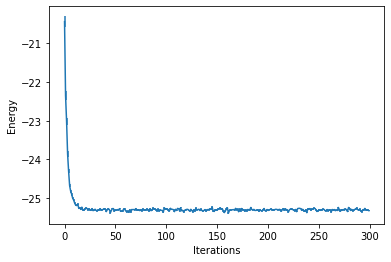

In [13]:
from matplotlib import pyplot as plt
plt.errorbar(log.data["Energy"].iters,log.data["Energy"].Mean,yerr=log.data["Energy"].Sigma)
plt.xlabel('Iterations')
plt.ylabel('Energy')

## 6. Neural-Network Quantum State 

We now want to use a more sofisticated ansatz, based on a neural network representation of the wave function. At this point, this is quite straightforward, since we can again take advantage of automatic differentiation. 

Let us define a simple fully-connected feed-forward network with a ReLu activation function and a sum layer. 

In [14]:
class FFN(nn.Module):
    
    alpha : int = 1
            
    @nn.compact
    def __call__(self, x):

        # the first layer is a dense layer
        dense = nn.Dense(features=self.alpha*x.shape[-1])
        
        y=dense(x)

        # the non-linearity is a simple ReLu    
        y=nn.relu(y)
        
        # sum the output
        return jnp.sum(y,axis=-1)
    
model=FFN(alpha=1)

vstate = nk.vqs.MCState(sampler, model, n_samples=1000)

We then proceed to the optimization as before. 

In [15]:
optimizer = nk.optimizer.Sgd(learning_rate=0.05)

gs = nk.driver.VMC(H, optimizer, variational_state=vstate,preconditioner=nk.optimizer.SR(diag_shift=0.1))

log=nk.logging.RuntimeLog()
gs.run(n_iter=300,out=log)

ffn_energy=vstate.expect(H)
error=abs((ffn_energy.mean-eig_vals[0])/eig_vals[0])
print("Optimized energy and relative error: ",ffn_energy,error)

100%|█████████████████████████████████████████████████████████████████| 300/300 [00:10<00:00, 28.40it/s, Energy=-25.433 ± 0.016 [σ²=0.254, R̂=0.9962]]


Optimized energy and relative error:  -25.441 ± 0.018 [σ²=0.322, R̂=1.0014] 0.0019597555202254947


## 7. Translation Symmetry 

In order to enforce spatial symmetries we can use some built-in functionalities of NetKet, in conjunction with equivariant layers. 

The first step is to construct explicitly a graph that contains the edges of our interactions, in this case this is a simple chain with periodic boundaries. NetKet has builtin several symmetry groups that can be used to target specific spatial symmetries. In this case for example after constructing the graph we can also print its translation group. 


In [16]:
graph=nk.graph.Chain(length=N,pbc=True)

print(graph.translation_group())

PermutationGroup(elems=[Id(), Translation([1]), Translation([2]), Translation([3]), Translation([4]), Translation([5]), Translation([6]), Translation([7]), Translation([8]), Translation([9]), Translation([10]), Translation([11]), Translation([12]), Translation([13]), Translation([14]), Translation([15]), Translation([16]), Translation([17]), Translation([18]), Translation([19])], degree=20)


Graphs are in general quite handy when defining hamiltonian terms on their edges. For example we can define our Hamiltonian as 

In [17]:
Gamma=-1
H = sum([Gamma*sigmax(hi,i) for i in range(N)])

V=-1
H += sum([V*sigmaz(hi,i)*sigmaz(hi,j) for (i,j) in graph.edges()])

We now write a model with an invariant transformation given by the translation group. Notice that we will now use NetKet's own ```nn``` module, instead of Flax, since it contains several additions and also an extended and seamless support for complex layers/parameters.  

In [18]:
import netket.nn as nknn

class SymmModel(nknn.Module):
    alpha: int

    @nknn.compact
    def __call__(self, x):
        
        x= nknn.DenseSymm(symmetries=graph.translation_group(),features=self.alpha)(x)
        x =nn.relu(x)

        # sum the output
        return jnp.sum(x,axis=-1)


sampler = nk.sampler.MetropolisLocal(hi)

#Let us define a model with 4 features per symmetry
model=SymmModel(alpha=4)

vstate = nk.vqs.MCState(sampler, model, n_samples=1000)

vstate.n_parameters

84

As it can be seen, the number of parameters of this model is greatly reduced, because of the symmetries that impose constraints on the weights of the dense layers. We can now optimize the model, using a few more optimization steps than before.  

In [19]:
gs = nk.driver.VMC(H, optimizer, variational_state=vstate,preconditioner=nk.optimizer.SR(diag_shift=0.1))

log=nk.logging.RuntimeLog()
gs.run(n_iter=600,out=log)

symm_energy=vstate.expect(H)
error=abs((symm_energy.mean-eig_vals[0])/eig_vals[0])
print("Optimized energy and relative error: ",symm_energy,error)

100%|██████████████████████████████████████████████████████████████| 600/600 [00:34<00:00, 17.45it/s, Energy=-25.4902 ± 0.0013 [σ²=0.0016, R̂=0.9982]]


Optimized energy and relative error:  -25.4918 ± 0.0019 [σ²=0.0038, R̂=0.9977] 3.361849849452602e-05


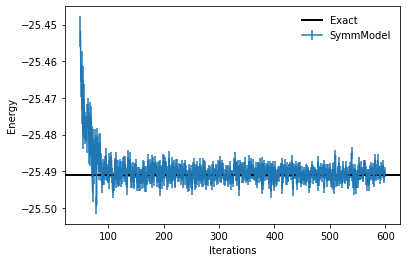

In [20]:
from matplotlib import pyplot as plt
plt.errorbar(log.data["Energy"].iters[50:],log.data["Energy"].Mean[50:],yerr=log.data["Energy"].Sigma[50:],label="SymmModel")
plt.axhline(y=eig_vals[0], xmin=0, xmax=log.data["Energy"].iters[-1], linewidth=2, color="k", label="Exact")
plt.xlabel('Iterations')
plt.ylabel('Energy')
plt.legend(frameon=False)

## 8. Measuring Other Properties

Once the model has been optimized, we can of course measure also other observables that are not the energy. For example, we could decide to measure the value of the nearest-neighbor $X-X$ correlator 


In [21]:
corr = sum([sigmax(hi,i)*sigmax(hi,j) for (i,j) in graph.edges()])

In [22]:
vstate.n_samples=100000

In [23]:
vstate.expect(corr)

10.870 ± 0.035 [σ²=31.245, R̂=1.0003]

And we can further compare this to the exact ED result. 

In [27]:
psi = eig_vecs[:, 0]
exact_corr=psi@(corr.to_sparse()@psi)
print(exact_corr)

10.85224871312775
